In [1]:
import networkx as nx
import pandas as pd
from datetime import datetime
import numpy as np
from numpy.random import rand
from numpy import exp

In [2]:
G = nx.read_gml("municipios_br.gml")
G = nx.relabel_nodes(G,lambda x: int(x))

In [3]:
data_dict = dict(G.nodes.data("CD_MUN"))

In [4]:
data = pd.read_csv('caso_full.csv')

In [5]:
data = data[(data['city'].isnull() == False) & (data['is_repeated'] == False)]
a = ['city_ibge_code','order_for_place','date','epidemiological_week',
 'last_available_confirmed_per_100k_inhabitants','last_available_confirmed',
 'last_available_death_rate']
columns_to_drop = ['state','city','place_type','last_available_confirmed',
                   'last_available_date','estimated_population',
                  'is_last','is_repeated']
data.drop(columns=columns_to_drop,inplace=True)
data['date'] = pd.to_datetime(data['date'],format='%Y-%m-%d')
data.epidemiological_week -= data.epidemiological_week.min()

In [6]:
grouped = data[["last_available_confirmed_per_100k_inhabitants","city_ibge_code","date"]].groupby('city_ibge_code')

In [7]:
n = data["city_ibge_code"].nunique()
codes = data["city_ibge_code"].unique()

In [8]:
min_date = data["date"].min()
max_date = data["date"].max()

In [9]:
max_date

Timestamp('2021-10-07 00:00:00')

In [10]:
delta = max_date - min_date

In [11]:
dates = pd.date_range(start=min_date, end=max_date, freq='D')
i = 0
X = np.zeros((len(grouped),delta.days + 1))
for group, data in grouped:
    series = data[["last_available_confirmed_per_100k_inhabitants","date"]]
    series = series.set_index("date").reindex(dates).interpolate().ffill().fillna(0)
    shape = series.shape
    X[i,:] = series.values.reshape(len(series))
    if data_dict[i] != str(group)[:-2]:
        print(data_dict[i],group)
    i += 1

In [12]:
zeros = np.zeros(len(grouped), dtype=bool)
true_indices = np.random.choice(len(grouped),2)
np.put(zeros,true_indices,True)
zeros

array([False, False, False, ..., False, False, False])

In [13]:
def gen_candidate_no_constraint(nodes,curr):
    candidate = curr
    curr_idx = np.nonzero(curr)[0]
    leave_basis = np.random.choice(curr_idx)
    candidate[leave_basis] = False
    #enter_basis = np.random.choice(np.where(candidate == False)[0],1)
    enter_basis = np.random.choice(np.append(nodes,leave_basis),1)
    candidate[enter_basis] = True
    return candidate

In [14]:
def gen_candidate_with_constraint(G,nodes,curr):
    candidate = gen_candidate_no_constraint(nodes.copy(),curr.copy())
    #print(np.count_nonzero(candidate),len(nodes))
    curr_idx = np.nonzero(candidate)[0]
    SG = G.subgraph(curr_idx)
    while not nx.is_connected(SG):
        candidate = gen_candidate_no_constraint(nodes.copy(),curr.copy())
        curr_idx = np.nonzero(candidate)[0]
        SG = G.subgraph(curr_idx)
        #print(np.count_nonzero(candidate),len(nodes),e,l)
    return candidate

In [15]:
def reachble_nodes(G,curr_idx):
    U = set()
    queuque = list(curr_idx)
    while len(queuque) > 0:
        v = queuque.pop(0)
        if v not in U:
            U.add(v)
            neighbors = dict(nx.bfs_successors(G, source=v, depth_limit=1))[v]
            queuque.extend(neighbors)
    return list(U)

In [16]:
def generate_candidate(nodes,curr,constraint=False):
    curr_idx = np.nonzero(curr)[0]
    if constraint:
        a = reachble_nodes(G,curr_idx)
        possible_choices = np.delete(a,np.isin(a,curr_idx))
        return gen_candidate_with_constraint(G,possible_choices,curr)
    else:
        possible_choices = np.delete(nodes,np.isin(nodes,curr_idx))
        return gen_candidate_no_constraint(possible_choices,curr)

In [17]:
a = dict(nx.bfs_successors(G, source=0, depth_limit=1))[0]

In [18]:
list(set(a))

[13, 45, 19, 20, 22, 25, 28]

In [19]:
np.array([1])[0]

1

In [20]:
def generate_candidate0(len_x,k,constraint=False):
    best = np.zeros(len_x, dtype=bool)
    if constraint:
        ini = np.random.choice(len_x,1)[0]
        U = set()
        queuque = [ini]
        total = 0
        while total < k:
            v = queuque.pop(0)
            if v not in U:
                U.add(v)
                total += 1
                neighbors = dict(nx.bfs_successors(G, source=v, depth_limit=1))[v]
                queuque.extend(neighbors)
        np.put(best,list(U),True)
        return best
    else:
        true_indices = np.random.choice(len_x,k)
        np.put(best,true_indices,True)
        return best

In [21]:
def objective(X,choice):
    return -np.linalg.slogdet(np.cov(X[choice,:]))[1]

# simulated annealing algorithm
def simulated_annealing(objective, n_iterations, temp, X, k,constraint=False):
    # generate an initial point
    len_x = X.shape[0]
    nodes = np.arange(len_x)
    best = generate_candidate0(len_x,k,constraint)
    print(best)
    # evaluate the initial point
    best_eval = objective(X,best)
    # current working solution
    curr, curr_eval = best, best_eval
    # run the algorithm
    for i in range(n_iterations):
        # take a step
        candidate = generate_candidate(nodes,curr,constraint)
        # evaluate candidate point
        candidate_eval = objective(X,candidate)
        # check for new best solution
        if candidate_eval < best_eval:
            # store new best point
            best, best_eval = candidate, candidate_eval
            # report progress
            print('>%d f(%s) = %.5f' % (i, best, best_eval))
        # difference between candidate and current point evaluation
        diff = candidate_eval - curr_eval
        # calculate temperature for current epoch
        t = temp / float(i + 1)
        # calculate metropolis acceptance criterion
        metropolis = exp(-diff / t)
        # check if we should keep the new point
        if diff < 0 or rand() < metropolis:
            # store the new current point
            curr, curr_eval = candidate, candidate_eval
    return [best, best_eval]

In [22]:
# define the total iterations
n_iterations = 10000
# initial temperature
temp = 1000
best, best_eval = simulated_annealing(objective, n_iterations, temp, X, 300)

[False False False ...  True False False]
>0 f([False False False ...  True False False]) = -1987.61779
>4 f([False False False ...  True False False]) = -1989.55274
>12 f([False False False ...  True False False]) = -1991.72535
>13 f([False False False ...  True False False]) = -1991.72581
>14 f([False False False ...  True False False]) = -1992.77747
>26 f([False False False ...  True False False]) = -1994.80062
>27 f([False False False ...  True False False]) = -1994.88074
>56 f([False False False ... False False False]) = -1995.00641
>57 f([False False False ... False False False]) = -1995.50686
>58 f([False False False ... False False False]) = -1995.72742
>60 f([False False False ... False False False]) = -1998.62973
>64 f([False False False ... False False False]) = -2000.78863
>65 f([False False False ... False False False]) = -2001.54914
>789 f([False False False ... False False False]) = -2001.89165
>848 f([False False False ... False False False]) = -2002.11272
>949 f([False

In [34]:
#!pip install libpysal
#!pip install geopandas
import geopandas as gpd
municipios = gpd.read_file('BR_Municipios_2020/BR_Municipios_2020.shp')
m = municipios.geometry.to_crs(epsg=5641)
centroids = np.column_stack((m.centroid.x, m.centroid.y))
positions = dict(zip(G.nodes, centroids))

In [44]:
color_map = []
idx = np.nonzero(best)[0]
for node in G:
    if node in idx:
        color_map.append('blue')
    else: 
        color_map.append('green') 

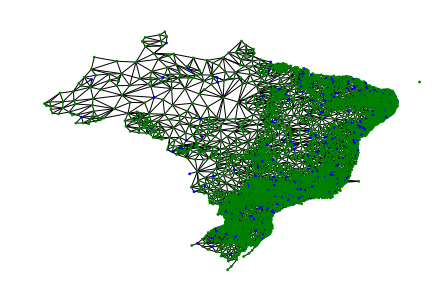

In [45]:
import matplotlib.pyplot as plt
nx.draw(G, positions, node_color=color_map, with_labels=False,node_size=3)
plt.show()

In [26]:
best2, best_eval2 = simulated_annealing(objective, n_iterations, temp, X, 300,True)

[False False False ... False False False]
>2 f([False False False ... False False False]) = -1778.93936
>7 f([False False False ... False False False]) = -1779.10742
>8 f([False False False ... False False False]) = -1779.82838
>9 f([False False False ... False False False]) = -1785.93107
>10 f([False False False ... False False False]) = -1787.27131
>16 f([False False False ... False False False]) = -1788.87062
>20 f([False False False ... False False False]) = -1788.88765
>21 f([False False False ... False False False]) = -1790.32574
>25 f([False False False ... False False False]) = -1790.85692
>26 f([False False False ... False False False]) = -1791.83742
>27 f([False False False ... False False False]) = -1792.37244
>29 f([False False False ... False False False]) = -1793.72777
>30 f([False False False ... False False False]) = -1794.36592
>40 f([False False False ... False False False]) = -1795.10685
>42 f([False False False ... False False False]) = -1800.61620
>43 f([False Fals

>643 f([False False False ... False  True False]) = -1946.45265
>661 f([False False False ... False  True False]) = -1947.31420
>662 f([False False False ... False  True False]) = -1947.51107
>664 f([False False False ... False  True False]) = -1950.16084
>667 f([False False False ... False  True False]) = -1951.95264
>668 f([False False False ... False  True False]) = -1953.07626
>669 f([False False False ... False  True False]) = -1954.71913
>670 f([False False False ... False  True False]) = -1955.49486
>671 f([False False False ... False  True False]) = -1956.51424
>674 f([False False False ... False  True False]) = -1956.67773
>676 f([False False False ... False  True False]) = -1958.52333
>682 f([False False False ... False  True False]) = -1959.13716
>684 f([False False False ... False  True False]) = -1960.43494
>685 f([False False False ... False  True False]) = -1961.55350
>695 f([False False False ... False  True False]) = -1961.95103
>704 f([False False False ... False  Tru

>1305 f([False False False ... False  True False]) = -2075.39401
>1306 f([False False False ... False  True False]) = -2077.34520
>1307 f([False False False ... False  True False]) = -2078.17232
>1310 f([False False False ... False  True False]) = -2078.75935
>1312 f([False False False ... False  True False]) = -2079.59324
>1316 f([False False False ... False  True False]) = -2079.85734
>1318 f([False False False ... False  True False]) = -2080.53975
>1319 f([False False False ... False  True False]) = -2081.82257
>1321 f([False False False ... False  True False]) = -2082.52916
>1325 f([False False False ... False  True False]) = -2082.95608
>1327 f([False False False ... False  True False]) = -2083.82780
>1328 f([False False False ... False  True False]) = -2083.85658
>1334 f([False False False ... False  True False]) = -2088.18374
>1337 f([False False False ... False  True False]) = -2088.84507
>1338 f([False False False ... False  True False]) = -2089.48720
>1339 f([False False Fals

>2100 f([False False False ... False False False]) = -2178.36627
>2103 f([False False False ... False False False]) = -2178.36742
>2106 f([False False False ... False False False]) = -2178.68720
>2109 f([False False False ... False False False]) = -2178.69688
>2115 f([False False False ... False False False]) = -2180.48495
>2119 f([False False False ... False False False]) = -2182.70576
>2120 f([False False False ... False False False]) = -2182.74761
>2122 f([False False False ... False False False]) = -2183.49459
>2124 f([False False False ... False False False]) = -2183.54223
>2126 f([False False False ... False False False]) = -2184.00516
>2133 f([False False False ... False False False]) = -2184.27329
>2137 f([False False False ... False False False]) = -2185.00155
>2139 f([False False False ... False False False]) = -2185.20969
>2144 f([False False False ... False False False]) = -2185.23274
>2149 f([False False False ... False False False]) = -2185.50988
>2150 f([False False Fals

>3319 f([False False False ... False False False]) = -2277.05183
>3326 f([False False False ... False False False]) = -2279.54472
>3330 f([False False False ... False False False]) = -2279.94436
>3334 f([False False False ... False False False]) = -2280.13327
>3356 f([False False False ... False False False]) = -2281.87650
>3365 f([False False False ... False False False]) = -2282.87484
>3376 f([False False False ... False False False]) = -2283.10656
>3384 f([False False False ... False False False]) = -2283.45754
>3426 f([False False False ... False False False]) = -2284.96033
>3438 f([False False False ... False False False]) = -2285.95310
>3446 f([False False False ... False False False]) = -2285.99699
>3449 f([False False False ... False False False]) = -2286.12787
>3460 f([False False False ... False False False]) = -2286.46348
>3462 f([False False False ... False False False]) = -2288.06700
>3464 f([False False False ... False False False]) = -2288.55189
>3480 f([False False Fals

>5896 f([False False False ... False False False]) = -2346.17999
>5925 f([False False False ... False False False]) = -2346.89879
>5934 f([False False False ... False False False]) = -2347.04048
>5969 f([False False False ... False False False]) = -2347.31908
>5970 f([False False False ... False False False]) = -2347.44552
>5990 f([False False False ... False False False]) = -2347.48727
>6102 f([False False False ... False False False]) = -2347.57485
>6103 f([False False False ... False False False]) = -2347.61268
>6117 f([False False False ... False False False]) = -2347.97558
>6194 f([False False False ... False False False]) = -2348.19124
>6196 f([False False False ... False False False]) = -2348.46131
>6212 f([False False False ... False False False]) = -2348.57435
>6217 f([False False False ... False False False]) = -2348.64237
>6226 f([False False False ... False False False]) = -2348.76715
>6242 f([False False False ... False False False]) = -2348.98626
>6307 f([False False Fals

In [43]:
color_map = []
idx = np.nonzero(best2)[0]
for node in G:
    if node in idx:
        color_map.append('blue')
    else: 
        color_map.append('green') 

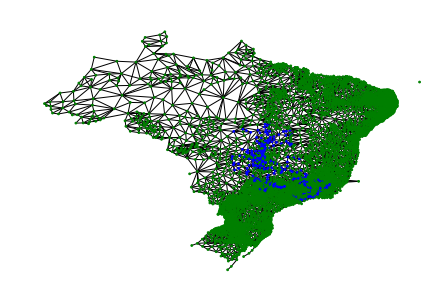

In [41]:
import matplotlib.pyplot as plt
nx.draw(G, positions, node_color=color_map, with_labels=False,node_size=3)
plt.show()

In [46]:
np.count_nonzero(best2)

300

In [48]:
len(G.nodes())

5570

In [49]:
len(G.edges)

16470